In [1]:
import pandas
import tensorflow
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 이 데이터셋은 **명확한 1회 세션의 SessionID를 포함하지 않음**


- **Rating 정보가 포함.** 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있음.


- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 **경과된 초 단위 시간**이 기재

### 유저 수, 아이템 수

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### Rating 카테고리별 개수

In [4]:
data.Rating.value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64

# 데이터 전처리

### Length
- 각 ID가 대략 몇 개의 클릭 데이터를 갖는지
- UserId를 공유하는 데이터 row의 개수


**즉, 해당 사용자가 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)를 확인**

In [5]:
action_length = data.groupby('UserId').size()
action_length

# 명확한 1회 세션의 데이터를 포함하고 있는 것이 아니기 때문에 변수명을 session_length -> action_length로 변경

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

- 중앙값, 평균

In [6]:
action_length.median(), action_length.mean()

(96.0, 165.5975165562914)

- 최솟값, 최댓값

In [7]:
action_length.min(), action_length.max()

(20, 2314)

- 99.9%

In [8]:
action_length.quantile(0.999)

1343.181000000005

- 99%

In [9]:
action_length.quantile(0.99)

906.659999999998

각 세션의 길이는 보통 96~166 정도, 99.9% 세션은 길이가 1343이하

**길이가 2314인 세션은 뭔가 이상**

In [10]:
long_action = action_length[action_length==2314].index[0]
data[data['UserId']==long_action]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


Time은 경과된 **초 단위 시간**이 기재된 것이기 때문에 1초가 증가하면 1이 증가하는 식으로 기록된다.

위의 DataFrame에서 여러 개의 아이템을 동시에 혹은 1초가 되지 않는 시간 동안 클릭했다고 기록되어있다.

## action 길이 시각화

In [11]:
length_count = action_length.groupby(action_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
                                    #누적합
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_999

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
888    0.989073
893    0.989404
894    0.989570
900    0.989735
903    0.989901
Length: 684, dtype: float64

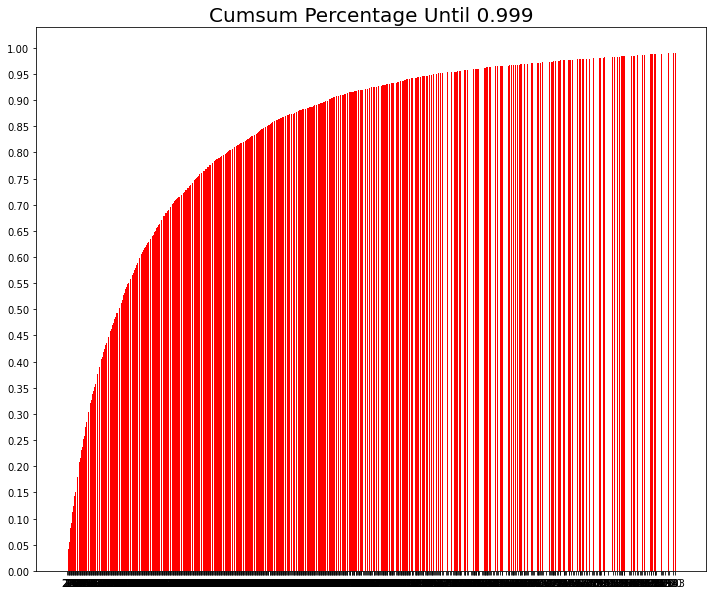

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
       height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

# x축 -> action 길이
# y축 -> 분포 누적합

## Time
- 추천 시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요
- 데이터가 발생한 시간

In [13]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

956703932
1046454590


가장 최근에 발생한 데이터와 가장 예전에 발생한 데이터의 시간 차이는 **89750658초**이다.

이는 **1038일 18시간 44분 18초**이며,

대략적으로 **2년 309일** 정도의 차이가 존재한다.

기존 노드에서는 6개월 정도의 데이터였고, 해당 데이터는 거의 3년이 되는 데이터를 포함하고 있기 때문에

1달이 아닌 1년 간의 데이터를 반영하고자 한다.

In [14]:
type(latest)

numpy.int64

latest는 int 객체이기 때문에 int 객체와 사칙연산이 가능하다

In [15]:
year_ago = latest - 31536000 # 최종 날짜로부터 365일(31536000초) 이전 날짜를 구함
data = data[data['Time'] > year_ago]  # 구한 날짜 이후의 데이터만 모음
data

,UserId,ItemId,Rating,Time
5170,36,1387,5,1015904819
5267,36,1201,4,1015904819
5122,36,1291,5,1015904836
5123,36,2167,5,1015904905
5290,36,2951,4,1015904905
...,...,...,...,...
992358,5996,3835,3,1020113184
992279,5996,2422,3,1020113225
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


## Data Cleansing
- 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거

In [16]:
# short_action을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 action이 생길 수 있음
# 이를 위해 반복문을 통해 지속적으로 제거

def cleanse_short_action(data: pd.DataFrame, shortest):
    action_len = data.groupby('UserId').size()
    action_use = action_len[action_len >= shortest].index
    data = data[data['UserId'].isin(action_use)]
    return data
# User 아이디가 shortest보다 더 많이 나온 action만 추림


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data
# 아이템 아이디가 least_click보다 더 많이 검색된 아이템만 추림


def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
                                                                # 반환값의 데이터 타입을 지정(주석처리)
    while True :
        before_len = len(data)
        data = cleanse_short_action(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data
# 위 둘의 교집합

In [17]:
cleanse_unpopular_item(data, 5)

,UserId,ItemId,Rating,Time
5170,36,1387,5,1015904819
5267,36,1201,4,1015904819
5122,36,1291,5,1015904836
5123,36,2167,5,1015904905
5290,36,2951,4,1015904905
...,...,...,...,...
992358,5996,3835,3,1020113184
992279,5996,2422,3,1020113225
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


In [18]:
cleanse_short_action(data, 2)

,UserId,ItemId,Rating,Time
5170,36,1387,5,1015904819
5267,36,1201,4,1015904819
5122,36,1291,5,1015904836
5123,36,2167,5,1015904905
5290,36,2951,4,1015904905
...,...,...,...,...
992358,5996,3835,3,1020113184
992279,5996,2422,3,1020113225
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


In [19]:
cleanse_recursive(data, shortest=2, least_click=5)

,UserId,ItemId,Rating,Time
5170,36,1387,5,1015904819
5267,36,1201,4,1015904819
5122,36,1291,5,1015904836
5123,36,2167,5,1015904905
5290,36,2951,4,1015904905
...,...,...,...,...
992358,5996,3835,3,1020113184
992279,5996,2422,3,1020113225
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


In [20]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
5170,36,1387,5,1015904819
5267,36,1201,4,1015904819
5122,36,1291,5,1015904836
5123,36,2167,5,1015904905
5290,36,2951,4,1015904905
...,...,...,...,...
992358,5996,3835,3,1020113184
992279,5996,2422,3,1020113225
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


# Train / Test / Val

In [21]:
def split_by_date(data: pd.DataFrame, n_seconds : int):
    final_time = data['Time'].max()
    action_last_time = data.groupby('UserId')['Time'].max()
    action_in_train = action_last_time[action_last_time < final_time - n_seconds].index
    action_in_test = action_last_time[action_last_time >= final_time - n_seconds].index
    
    before_date = data[data['UserId'].isin(action_in_train)]
    after_date = data[data['UserId'].isin(action_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

가장 마지막 7일 기간 동안을 Test로, 7일 전 3주를 validation으로, 나머지를 train으로 설정

Ex.

train : 1월 ~ 11월

validation : 12월 첫 째 주 ~ 12월 셋 째 주

test : 12월 넷 째 주

In [22]:
tr, test = split_by_date(data, n_seconds=604800)  # 7일 -> 604800초
tr, val = split_by_date(tr, n_seconds=1814400)   # 3주 -> 21일 -> 1814400초

### data에 대한 정보 살펴보기

In [23]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time: {data["Time"].min()}\n'
          f'\t Last Time: {data["Time"].max()}\n'
          )

In [24]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 12566
	 Users: 373
	 Items: 1523
	 First Time: 1014923199
	 Last Time: 1043902000

* valid Set Stats Info
	 Events: 3513
	 Users: 60
	 Items: 1324
	 First Time: 1014955410
	 Last Time: 1045841716

* test Set Stats Info
	 Events: 2537
	 Users: 33
	 Items: 1244
	 First Time: 1014979250
	 Last Time: 1046454590



### train set에 없는 아이템이 val, test 기간에 생길 수 있으므로 train data를 기준으로 인덱싱

In [25]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x : id2idx.get(x, -1))
                    # id2idx에 없는 아이템은 모르는 값(-1) 처리
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [26]:
tr

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,1015904819,0
5267,36,1201,4,1015904819,1
5122,36,1291,5,1015904836,2
5123,36,2167,5,1015904905,3
5290,36,2951,4,1015904905,4
...,...,...,...,...,...
992358,5996,3835,3,1020113184,1360
992279,5996,2422,3,1020113225,1088
992702,5996,168,3,1031058746,1372
992459,5996,339,4,1033997079,242


In [27]:
val

,UserId,ItemId,Rating,Time,item_idx
28484,195,2890,3,1014955410,762
28123,195,1827,5,1014958395,1151
28067,195,1586,3,1014959821,1048
28179,195,2579,4,1014961130,861
28116,195,3354,1,1014962724,550
...,...,...,...,...,...
941574,5682,1246,5,1036094329,462
941832,5682,527,5,1036187226,273
941770,5682,3358,4,1037482366,1471
941703,5682,1302,4,1043302769,886


In [28]:
test

,UserId,ItemId,Rating,Time,item_idx
33854,229,3897,4,1039501583,499
33845,229,3949,5,1039501608,396
33980,229,3554,4,1039501688,547
34008,229,3598,4,1039501744,291
33901,229,3317,4,1039501785,515
...,...,...,...,...,...
984731,5950,3948,4,1046369637,502
984682,5950,3578,4,1046369670,599
984475,5950,3793,3,1046369710,867
984660,5950,3555,2,1046369737,1075


## 데이터 저장

In [29]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Pipe Line

### 데이터가 주어지면 action이 시작되는 인덱스를 담는 값과 action을 새로 인덱싱한 값을 갖는 클래스

In [30]:
class ActionDataset:
    """Credit to yhs-968/pyGRU4REC."""
    
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.action_idx = np.arange(self.df['UserId'].nunique())  # Indexing to UserId
        
    def get_click_offsets(self):
        """
        Return the indexes of the first click of each User IDs
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

### train데이터로 ActionDataset 객체를 만들고 인스턴스 변수들을 살펴보기

In [31]:
tr_dataset = ActionDataset(tr)
tr_dataset.df.head(20)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,1015904819,0
5267,36,1201,4,1015904819,1
5122,36,1291,5,1015904836,2
5123,36,2167,5,1015904905,3
5290,36,2951,4,1015904905,4
5359,36,2115,5,1015904905,5
5073,36,1912,5,1015904924,6
5113,36,2662,3,1015904924,7
5366,36,2985,4,1015904941,8
5145,36,198,5,1015904988,9


In [32]:
tr.UserId.value_counts()

1194    502
4186    265
2847    238
5878    231
1755    223
       ... 
5437      2
5450      2
3473      2
696       2
4680      2
Name: UserId, Length: 373, dtype: int64

- click_offsets : **각 세션이 시작된 인덱스**

In [33]:
tr_dataset.click_offsets

array([    0,    30,   137,   144,   235,   247,   252,   254,   313,
         315,   336,   342,   359,   374,   385,   434,   503,   515,
         596,   638,   673,   679,   687,   707,   716,   726,   732,
         736,   740,   777,   806,   820,   826,   847,   957,   963,
        1001,  1016,  1031,  1054,  1056,  1105,  1112,  1138,  1142,
        1144,  1287,  1293,  1299,  1344,  1352,  1513,  1523,  1563,
        1567,  1575,  1577,  1579,  1595,  1598,  1639,  1653,  1658,
        1668,  1677,  1730,  1843,  1894,  1908,  1921,  1927,  2051,
        2059,  2062,  2066,  2568,  2587,  2618,  2632,  2634,  2658,
        2661,  2667,  2676,  2684,  2687,  2731,  2795,  2799,  2805,
        2842,  2867,  2901,  3000,  3059,  3094,  3141,  3152,  3200,
        3308,  3311,  3328,  3346,  3361,  3422,  3435,  3463,  3527,
        3551,  3564,  3569,  3621,  3844,  3874,  3884,  3950,  3956,
        4020,  4034,  4074,  4241,  4326,  4427,  4483,  4501,  4507,
        4509,  4562,

- action_idx : **각 세션을 인덱싱한 np.array**

In [34]:
tr_dataset.action_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## ActionDataLoader
- ActionDataset 객체를 받아서 **Action-Parallel mini-batch를 만드는 클래스**
- **_ _iter_ _ 메서드** : 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield
- **mask** : 후에 RNN Cell State를 초기화하는데 사용

In [35]:
class ActionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: ActionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing action-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the actions to be terminated
        """

        start, end, mask, last_action, finished = self.initialize()  # initialize 메소드에서 확인
        """
        start : Index Where Action Start
        end : Index Where Action End
        mask : indicator for the actions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Actions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_action, finished = self.update_status(start, end, min_len, last_action, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 action Index를 가져옴
        last_action = self.batch_size - 1    # 마지막으로 다루고 있는 action Index를 저장
        start = self.dataset.click_offsets[self.dataset.action_idx[first_iters]]       # data 상에서 action이 시작된 위치를 가져옴
        end = self.dataset.click_offsets[self.dataset.action_idx[first_iters] + 1]  # action이 끝난 위치 바로 다음 위치를 가져옴
        mask = np.array([])   # action의 모든 아이템을 다 돌은 경우 mask에 추가
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수
        return start, end, mask, last_action, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_action: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줌
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 action이 끝났다는 뜻입니다. mask에 기록

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 action 개수만큼 새로운 action을 돌 것임
            new_action = last_action + i  
            if new_action > self.dataset.action_idx[-1]:  # 만약 새로운 action이 마지막 action index보다 크다면 모든 학습데이터를 돈 것임
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.action_idx[new_action]]     # 종료된 action 대신 새로운 action의 시작점을 기록
            end[idx] = self.dataset.click_offsets[self.dataset.action_idx[new_action] + 1]

        last_action += len(mask)  # 마지막 세션의 위치를 기록
        return start, end, mask, last_action, finished

In [36]:
tr_data_loader = ActionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,1015904819,0
5267,36,1201,4,1015904819,1
5122,36,1291,5,1015904836,2
5123,36,2167,5,1015904905,3
5290,36,2951,4,1015904905,4
5359,36,2115,5,1015904905,5
5073,36,1912,5,1015904924,6
5113,36,2662,3,1015904924,7
5366,36,2985,4,1015904941,8
5145,36,198,5,1015904988,9


In [37]:
iter_ex = iter(tr_data_loader)

In [38]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  30 132 138]
Label Item Idx are :       [  1  21 133 139]
Previous Masked Input Idx are []


# Modeling
## Evaluation Metric

Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 

유저가 클릭/ 구매한 n개의 아이템이 많아야 좋음

이 때문에 recall의 개념을 확장한 **recall@k 지표**, 

precision의 개념을 확장한 **Mean Average Precision@k 지표** 등을 사용

추천에서는 **몇 번째로 맞추느냐**도 중요

구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것

따라서 순서에 민감한 지표인 **MRR, NDCG** 같은 지표도 사용

- **이번 자료에서는 MRR과 Recall@k를 사용**

**MRR** : 정답 아이템이 나온 순번의 역수 값

MRR 설명 링크 : https://lamttic.github.io/2020/03/20/01.html

따라서 **정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것**이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것

In [39]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0
    
def recall_k(pred, truth: int, k : int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Model Architecture

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [41]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state = True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['Accuracy'])
    model.summary()
    return model

In [42]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_actions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k
        
args = Args(tr, val, test, batch_size = 32, hsz=50, drop_rate=0.1, lr= 0.001, epochs=3, k=20)

In [43]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 1523)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      236250    
_________________________________________________________________
dropout (Dropout)            (32, 50)                  0         
_________________________________________________________________
dense (Dense)                (32, 1523)                77673     
Total params: 313,923
Trainable params: 313,923
Non-trainable params: 0
_________________________________________________________________


In [44]:
# train셋으로 학습하면서 val 셋으로 검증

def train_model(model, args):
    train_dataset = ActionDataset(args.tr)
    train_loader = ActionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 action은 hidden_state를 초기화. 아래 메서드에서 확인

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")



def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옴
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옴
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인
    dataset = ActionDataset(data)
    loader = ActionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [45]:
# 학습 시간이 다소 오래 소요. 아래 주석 풀지 말기
train_model(model, args)

Evaluation:  53%|█████▎    | 57/107 [00:09<00:08,  5.75it/s]


	 - Recall@20 epoch 1: 0.042763
	 - MRR@20    epoch 1: 0.007042



Evaluation:  53%|█████▎    | 57/107 [00:09<00:08,  6.01it/s]


	 - Recall@20 epoch 2: 0.035636
	 - MRR@20    epoch 2: 0.005044



Evaluation:  53%|█████▎    | 57/107 [00:09<00:08,  5.91it/s]

	 - Recall@20 epoch 3: 0.031250
	 - MRR@20    epoch 3: 0.005123



## Inference
- 지금까지 작성한 모델이 테스트셋에 대해서 어느 정도 성능을 내는지 검증

In [46]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")
    
test_model(model, args, test)

Evaluation:   4%|▍         | 3/78 [00:00<00:12,  6.14it/s]

	 - Recall@20: 0.093750
	 - MRR@20: 0.013814



# 회고

이번 분석 데이터는 하나의 데이터가 한 Session을 뜻하는 것이기 아니기 때문에 Session 대신 Action의 개념으로 접근했다.

기본적인 Baseline으로 0.09의 성능이 나와 매우 당황스럽지만 어느 부분이 잘못된 것인지 잘 모르겠다.

발목 수술과 데이터톤, 감기몸살이 함께 어우러진 한 주여서 이번 익스를 제대로 해내지 못했다. 

시간이 부족해서 비록 지금 제출하지만 컨디션이 회복되고 나서 다시 여러 시도를 통해 성능을 향상시켜보고자 한다.